<a href="https://colab.research.google.com/github/Lxyyxxx/Colab/blob/main/DQN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install loguru

In [2]:
import tensorflow as tf
import numpy as np
import gym
import random
from loguru import logger
from typing import Any, Tuple, List
from collections import deque

In [3]:
class DQNModel(tf.keras.Model):
    def __init__(self, action_n: int) -> None:
        super().__init__()
        self.nn = [
            tf.keras.layers.Dense(128, activation='relu'),
            tf.keras.layers.Dense(128, activation='relu'),
            tf.keras.layers.Dense(action_n),
        ]

    def call(self, state: Any) -> Any:
        q = state
        for layer in self.nn:
            q = layer(q)
        return q

In [4]:
class ReplayMemory():
    def __init__(self, N: int) -> None:
        self.N = N
        self.q = deque(maxlen=N)

    def save_experience(self, s: Any, a: int, r: float, s_: Any, d: bool) -> None:
        self.q.append([s, a, r, s_, d])

    def sample_experience(self, batch_size: int) -> Tuple[List, List, List, List, List]:
        minibatch = random.sample(self.q, batch_size)
        s, a, r, s_, d = map(np.stack, zip(*minibatch))
        return s, a, r, s_, d

    def __len__(self) -> int:
        return len(self.q)

In [5]:
class DQNAgent():
    def __init__(
        self, 
        input_shape: tuple, 
        action_n: int, 
        memory_size: int = 20000, 
        batch_size: int = 32, 
        alpha: float = 0.001, 
        gamma: float = 0.99, 
        epsilon: float = 1.0, 
        epsilon_decrement: float = 0.995,
        epsilon_min: float = 0.1,
        update_frequency: int = 20
    ) -> None:
        self.action_n = action_n
        self.input_shape = input_shape
        self.memory_size = memory_size
        self.batch_size = batch_size
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_decrement = epsilon_decrement
        self.epsilon_min = epsilon_min
        self.update_frequency = update_frequency
        self.model = DQNModel(action_n)
        self.target_model = DQNModel(action_n)
        self.replay_memory = ReplayMemory(memory_size)
        self.global_step = 0
    
    def predict(self, state: Any) -> int:
        state = tf.expand_dims(tf.convert_to_tensor(state), 0)
        action = tf.argmax(self.model(state), axis=1).numpy()[0]
        return action

    def sample(self, state: Any) -> int:
        action = self.predict(state)
        # epsilon-greedy
        if np.random.random() < self.epsilon:
            action = np.random.choice(self.action_n)
        # update epsilon
        self.epsilon = max(self.epsilon_min, self.epsilon * self.epsilon_decrement)
        return action

    def learn(self) -> None:
        self.global_step += 1
        # learn
        # experience replay
        state, action, reward, state_, done = self.replay_memory.sample_experience(self.batch_size)
        with tf.GradientTape() as tape:
            predict_q = self.model(state)
            predict_future_q = self.target_model(state_)
            predict_action_q = tf.reduce_sum(tf.multiply(predict_q, tf.one_hot(action, self.action_n)), axis=1)
            target_q = reward + (1 - done) * self.gamma * np.max(predict_future_q, axis=1)
            loss = tf.keras.losses.MeanSquaredError()(predict_action_q, target_q)
        grads = tape.gradient(loss, self.model.trainable_variables)
        optimizer = tf.keras.optimizers.RMSprop(self.alpha)
        optimizer.apply_gradients(zip(grads, self.model.trainable_variables))
        # sync target
        if self.global_step % self.update_frequency == 0:
            self.update_target()

    def save_experience(self, s: Any, a: int, r: float, s_: Any, d: bool) -> None:
        self.replay_memory.save_experience(s, a, r, s_, d)

    def update_target(self) -> None:
        self.target_model.set_weights(self.model.get_weights())

    def save_model(self) -> None:
        self.model.save('dqn')

    def load_model(self) -> None:
        self.model = tf.keras.models.load_model('dqn')

In [6]:
def run_episode(env: gym.Wrapper, agent: DQNAgent, training: bool, batch_size: int = 32, render: bool = False) -> float:
    state = env.reset()
    done = False
    step = 0
    score = 0
    while not done:
        if render:
            env.render()
        step += 1
        action = agent.sample(state)
        state_, reward, done, info = env.step(action)
        score += reward
        agent.save_experience(state, action, reward, state_, done)
        if len(agent.replay_memory) > batch_size and training:
            agent.learn()
        state = state_
    return score

In [7]:
def warm(env: gym.Wrapper, agent: DQNAgent, warm_steps: int = 200) -> None:
    for warm_step in range(warm_steps):
        run_episode(env, agent, training=False)

def train(env: gym.Wrapper, agent: DQNAgent) -> None:
    score_result = []
    max_score = 0
    for episode in range(1000):
        score = run_episode(env, agent, training=True)
        score_result.append(score)
        if score > max_score:
            max_score = score
            logger.info('Episode {}: Best score {}'.format(episode, score))
        if score == max_score:
            agent.save_model()
        if episode % 50 == 0:
            logger.info('Episode {}: score {}'.format(episode, score))

    plt.title('Train Score Curve')
    plt.xlabel('Episode')
    plt.ylabel('Score')
    plt.plot(score_result, label='$Score$')
    plt.legend()
    plt.show()

def play(env: gym.Wrapper, agent: DQNAgent) -> None:
    score_result = []
    agent.load_model()
    for episode in range(5):
        score = run_episode(env, agent, training=False, render=False)
        score_result.append(score)
        logger.info('Round {}: score: {}'.format(episode, score))
    
    plt.title('Play Score Curve')
    plt.xlabel('Round')
    plt.ylabel('Score')
    plt.plot(score_result, label='$Score$')
    plt.legend()
    plt.show()

2021-10-04 15:19:06.426 | INFO     | __main__:train:13 - Episode 0: Best score 13.0


INFO:tensorflow:Assets written to: dqn/assets


2021-10-04 15:19:07.179 | INFO     | __main__:train:17 - Episode 0: score 13.0


INFO:tensorflow:Assets written to: dqn/assets


2021-10-04 15:19:11.375 | INFO     | __main__:train:13 - Episode 14: Best score 20.0


INFO:tensorflow:Assets written to: dqn/assets


2021-10-04 15:19:12.815 | INFO     | __main__:train:13 - Episode 16: Best score 25.0


INFO:tensorflow:Assets written to: dqn/assets


2021-10-04 15:19:13.975 | INFO     | __main__:train:13 - Episode 17: Best score 30.0


INFO:tensorflow:Assets written to: dqn/assets


2021-10-04 15:19:15.366 | INFO     | __main__:train:13 - Episode 18: Best score 39.0


INFO:tensorflow:Assets written to: dqn/assets


2021-10-04 15:19:24.255 | INFO     | __main__:train:13 - Episode 30: Best score 86.0


INFO:tensorflow:Assets written to: dqn/assets


2021-10-04 15:19:34.052 | INFO     | __main__:train:13 - Episode 40: Best score 88.0


INFO:tensorflow:Assets written to: dqn/assets


2021-10-04 15:19:36.911 | INFO     | __main__:train:13 - Episode 41: Best score 99.0


INFO:tensorflow:Assets written to: dqn/assets


2021-10-04 15:19:51.639 | INFO     | __main__:train:17 - Episode 50: score 60.0
2021-10-04 15:19:57.162 | INFO     | __main__:train:13 - Episode 53: Best score 100.0


INFO:tensorflow:Assets written to: dqn/assets


2021-10-04 15:20:03.041 | INFO     | __main__:train:13 - Episode 55: Best score 146.0


INFO:tensorflow:Assets written to: dqn/assets


2021-10-04 15:20:13.777 | INFO     | __main__:train:13 - Episode 58: Best score 200.0


INFO:tensorflow:Assets written to: dqn/assets
INFO:tensorflow:Assets written to: dqn/assets
INFO:tensorflow:Assets written to: dqn/assets
INFO:tensorflow:Assets written to: dqn/assets
INFO:tensorflow:Assets written to: dqn/assets
INFO:tensorflow:Assets written to: dqn/assets


2021-10-04 15:22:51.106 | INFO     | __main__:train:17 - Episode 100: score 108.0


INFO:tensorflow:Assets written to: dqn/assets
INFO:tensorflow:Assets written to: dqn/assets
INFO:tensorflow:Assets written to: dqn/assets
INFO:tensorflow:Assets written to: dqn/assets
INFO:tensorflow:Assets written to: dqn/assets
INFO:tensorflow:Assets written to: dqn/assets
INFO:tensorflow:Assets written to: dqn/assets


2021-10-04 15:24:52.321 | INFO     | __main__:train:17 - Episode 150: score 20.0
2021-10-04 15:25:06.842 | INFO     | __main__:train:17 - Episode 200: score 12.0
2021-10-04 15:25:18.841 | INFO     | __main__:train:17 - Episode 250: score 10.0
2021-10-04 15:25:30.564 | INFO     | __main__:train:17 - Episode 300: score 11.0
2021-10-04 15:25:46.003 | INFO     | __main__:train:17 - Episode 350: score 13.0
2021-10-04 15:25:59.594 | INFO     | __main__:train:17 - Episode 400: score 9.0
2021-10-04 15:26:12.956 | INFO     | __main__:train:17 - Episode 450: score 11.0


INFO:tensorflow:Assets written to: dqn/assets
INFO:tensorflow:Assets written to: dqn/assets
INFO:tensorflow:Assets written to: dqn/assets
INFO:tensorflow:Assets written to: dqn/assets
INFO:tensorflow:Assets written to: dqn/assets


2021-10-04 15:27:06.532 | INFO     | __main__:train:17 - Episode 500: score 9.0
2021-10-04 15:27:18.441 | INFO     | __main__:train:17 - Episode 550: score 10.0
2021-10-04 15:27:30.025 | INFO     | __main__:train:17 - Episode 600: score 10.0
2021-10-04 15:27:41.849 | INFO     | __main__:train:17 - Episode 650: score 10.0
2021-10-04 15:27:53.591 | INFO     | __main__:train:17 - Episode 700: score 15.0
2021-10-04 15:28:28.557 | INFO     | __main__:train:17 - Episode 750: score 24.0


INFO:tensorflow:Assets written to: dqn/assets


2021-10-04 15:29:40.560 | INFO     | __main__:train:17 - Episode 800: score 83.0
2021-10-04 15:30:30.508 | INFO     | __main__:train:17 - Episode 850: score 18.0
2021-10-04 15:30:53.061 | INFO     | __main__:train:17 - Episode 900: score 16.0
2021-10-04 15:31:13.896 | INFO     | __main__:train:17 - Episode 950: score 25.0


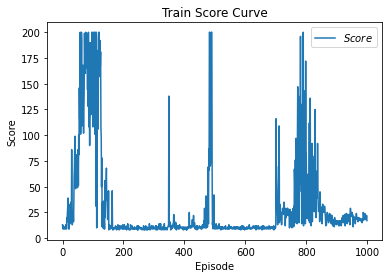

2021-10-04 15:31:36.283 | INFO     | __main__:play:32 - Round 0: score: 28.0
2021-10-04 15:31:36.328 | INFO     | __main__:play:32 - Round 1: score: 36.0
2021-10-04 15:31:36.362 | INFO     | __main__:play:32 - Round 2: score: 20.0
2021-10-04 15:31:36.389 | INFO     | __main__:play:32 - Round 3: score: 21.0
2021-10-04 15:31:36.426 | INFO     | __main__:play:32 - Round 4: score: 31.0


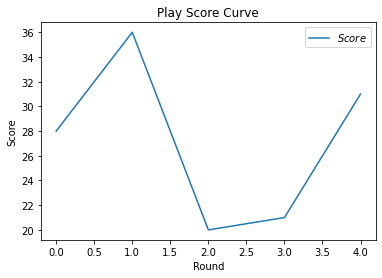

In [8]:
if __name__ == '__main__':
    import matplotlib.pyplot as plt

    env = gym.make('CartPole-v0')
    agent = DQNAgent(env.observation_space.shape, env.action_space.n)
    # warm
    warm(env, agent)
    # train
    train(env, agent)
    # play
    play(env, agent)